<a href="https://colab.research.google.com/github/fereidoon27/sample-colab/blob/main/pdb_compare_7JTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fereidoon27/jaxalpha.git

Cloning into 'jaxalpha'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 94 (delta 7), reused 92 (delta 5), pack-reused 0
Receiving objects: 100% (94/94), 2.24 MiB | 12.49 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [2]:
!pip install biopython numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.1 MB/s eta 0:00:00


In [3]:
!apt-get install dssp
!pip install py3Dmol

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcifpp-data libcifpp2
The following NEW packages will be installed:
  dssp libcifpp-data libcifpp2
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,967 kB of archives.
After this operation, 15.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcifpp-data all 2.0.5-1build1 [437 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcifpp2 amd64 2.0.5-1build1 [1,019 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dssp amd64 4.0.4-1 [511 kB]
Fetched 1,967 kB in 1s (2,314 kB/s)
Preconfiguring packages ...
Selecting previously unselected package libcifpp-data.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../libcifpp-data_2.0.5-1build1_all.deb ...
Unpacking libcifpp-data (2.0.5-1bu

In [4]:
import sys
from io import StringIO

def capture_and_save_output(func):
    def wrapper(*args, **kwargs):
        old_stdout = sys.stdout
        sys.stdout = StringIO()

        try:
            result = func(*args, **kwargs)
            output = sys.stdout.getvalue()
        finally:
            sys.stdout = old_stdout

        with open('/content/result_compare.txt', 'a') as f:
            f.write(f"Output of {func.__name__}:\n")
            f.write(output)
            f.write("\n\n")

        print(output)
        return result
    return wrapper

In [5]:
import IPython

ip = IPython.get_ipython()
ip.run_cell = capture_and_save_output(ip.run_cell)

In [6]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt

# Load structures
parser = PDB.PDBParser()
cor_structure = parser.get_structure("correct", "/content/jaxalpha/org_pdb_AF/7JTL/Cor_str.pdb")
query_structure = parser.get_structure("query", "/content/jaxalpha/pred_pdb_mmseq_gp/ranked_0/7JTL/query.pdb")

print("Structures loaded successfully.")

def calc_rmsd(struct1, struct2):
    atoms1 = [atom for atom in struct1.get_atoms() if atom.name == 'CA']
    atoms2 = [atom for atom in struct2.get_atoms() if atom.name == 'CA']

    if len(atoms1) != len(atoms2):
        print("Warning: Structures have different numbers of CA atoms.")
        return None

    coords1 = np.array([atom.coord for atom in atoms1])
    coords2 = np.array([atom.coord for atom in atoms2])

    diff = coords1 - coords2
    return np.sqrt(np.sum(diff * diff) / len(coords1))

rmsd_value = calc_rmsd(cor_structure, query_structure)
print(f"RMSD between structures: {rmsd_value:.4f} Å")



Structures loaded successfully.
RMSD between structures: 17.1331 Å



In [7]:
from Bio import PDB
import numpy as np

def estimate_secondary_structure(structure):
    ca_atoms = [atom for atom in structure.get_atoms() if atom.name == "CA"]
    ss = []
    for i in range(1, len(ca_atoms) - 1):
        v1 = ca_atoms[i-1].coord - ca_atoms[i].coord
        v2 = ca_atoms[i+1].coord - ca_atoms[i].coord
        angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        if 80 <= angle <= 120:
            ss.append('H')  # Helix
        elif 0 <= angle <= 50:
            ss.append('E')  # Sheet
        else:
            ss.append('C')  # Coil
    return ['C'] + ss + ['C']  # Add 'C' for the first and last residues

def compare_secondary_structure(struct1, struct2):
    ss1 = estimate_secondary_structure(struct1)
    ss2 = estimate_secondary_structure(struct2)

    matches = sum(1 for a, b in zip(ss1, ss2) if a == b)
    total = len(ss1)

    return matches / total if total > 0 else 0

ss_similarity = compare_secondary_structure(cor_structure, query_structure)
print(f"Secondary structure similarity: {ss_similarity:.2%}")

# Additional analysis
ss1 = estimate_secondary_structure(cor_structure)
ss2 = estimate_secondary_structure(query_structure)

print("Secondary structure composition:")
print("Correct structure:")
print(f"  Helix: {ss1.count('H') / len(ss1):.2%}")
print(f"  Sheet: {ss1.count('E') / len(ss1):.2%}")
print(f"  Coil:  {ss1.count('C') / len(ss1):.2%}")
print("Query structure:")
print(f"  Helix: {ss2.count('H') / len(ss2):.2%}")
print(f"  Sheet: {ss2.count('E') / len(ss2):.2%}")
print(f"  Coil:  {ss2.count('C') / len(ss2):.2%}")

Secondary structure similarity: 89.72%
Secondary structure composition:
Correct structure:
  Helix: 71.96%
  Sheet: 0.00%
  Coil:  28.04%
Query structure:
  Helix: 71.03%
  Sheet: 0.00%
  Coil:  28.97%



In [8]:
def residue_distances(struct1, struct2):
    distances = []
    for res1, res2 in zip(struct1.get_residues(), struct2.get_residues()):
        if res1.has_id("CA") and res2.has_id("CA"):
            distance = res1["CA"].coord - res2["CA"].coord
            distances.append(np.linalg.norm(distance))
    return distances

distances = residue_distances(cor_structure, query_structure)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("Residue-wise distances between structures")
plt.xlabel("Residue number")
plt.ylabel("Distance (Å)")
plt.savefig("/content/residue_distances.png")
plt.close()

print(f"Average residue distance: {np.mean(distances):.4f} Å")
print(f"Plot saved as residue_distances.png in /content directory")

Average residue distance: 15.8202 Å
Plot saved as residue_distances.png in /content directory



In [9]:
def count_hbonds(structure, distance_cutoff=3.5):
    hbonds = 0
    for residue in structure.get_residues():
        if residue.has_id("N") and residue.has_id("O"):
            n_atom = residue["N"]
            for other_residue in structure.get_residues():
                if other_residue.has_id("O"):
                    o_atom = other_residue["O"]
                    distance = n_atom - o_atom
                    if distance < distance_cutoff:
                        hbonds += 1
    return hbonds

cor_hbonds = count_hbonds(cor_structure)
query_hbonds = count_hbonds(query_structure)

print(f"Hydrogen bonds in correct structure: {cor_hbonds}")
print(f"Hydrogen bonds in query structure: {query_hbonds}")

Hydrogen bonds in correct structure: 265
Hydrogen bonds in query structure: 272



In [10]:
print("Comparison Summary:")
print(f"1. RMSD: {rmsd_value:.4f} Å")
print(f"2. Secondary Structure Similarity: {ss_similarity:.2%}")
print(f"3. Average Residue Distance: {np.mean(distances):.4f} Å")
print(f"4. Hydrogen Bonds: Correct - {cor_hbonds}, Query - {query_hbonds}")
print("5. Residue-wise distance plot saved as residue_distances.png")

Comparison Summary:
1. RMSD: 17.1331 Å
2. Secondary Structure Similarity: 89.72%
3. Average Residue Distance: 15.8202 Å
4. Hydrogen Bonds: Correct - 265, Query - 272
5. Residue-wise distance plot saved as residue_distances.png



In [11]:
import py3Dmol
from Bio import PDB
from Bio.PDB.Superimposer import Superimposer
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt

def structure_to_pdb_string(structure):
    io = PDB.PDBIO()
    io.set_structure(structure)
    pdb_string = StringIO()
    io.save(pdb_string)
    return pdb_string.getvalue()

def visualize_and_compare_structures(correct_path, query_path, width=800, height=500):
    # Load structures
    parser = PDB.PDBParser()
    cor_str = parser.get_structure("correct", correct_path)
    query_str = parser.get_structure("query", query_path)

    # Superimpose structures
    sup = Superimposer()
    ref_atoms = [atom for atom in cor_str.get_atoms() if atom.name == 'CA']
    alt_atoms = [atom for atom in query_str.get_atoms() if atom.name == 'CA']
    sup.set_atoms(ref_atoms, alt_atoms)
    sup.apply(query_str.get_atoms())

    # Create viewer
    view = py3Dmol.view(width=width, height=height)

    # Add correct structure
    view.addModel(structure_to_pdb_string(cor_str), "pdb")
    view.setStyle({'model': -1}, {'cartoon': {'color': 'blue'}})

    # Add query structure
    view.addModel(structure_to_pdb_string(query_str), "pdb")
    view.setStyle({'model': -1}, {'cartoon': {'color': 'red'}})

    # Zoom and render
    view.zoomTo()
    view.render()

    # Calculate RMSD
    rmsd = sup.rms

    # Calculate distances between corresponding CA atoms
    distances = [np.linalg.norm(ref.coord - alt.coord) for ref, alt in zip(ref_atoms, alt_atoms)]

    return view, cor_str, query_str, rmsd, distances

# Use the function
view, cor_str, query_str, rmsd, distances = visualize_and_compare_structures("/content/jaxalpha/org_pdb_AF/7JTL/Cor_str.pdb", "/content/jaxalpha/pred_pdb_mmseq_gp/ranked_0/7JTL/query.pdb")

from IPython.display import display, Image
import base64

# Display the visualization
view.show()

# Print RMSD and other statistics
print(f"RMSD after superimposition: {rmsd:.4f} Å")
print(f"Average distance between corresponding CA atoms: {np.mean(distances):.4f} Å")
print(f"Maximum distance between corresponding CA atoms: {np.max(distances):.4f} Å")

# Capture the image data
image_data = view.png()

# Check if image data was captured
if image_data is not None:
    # Save the image
    with open('/content/superimposed_structures.png', 'wb') as f:
        f.write(image_data)
    print("Superimposed structures image saved as superimposed_structures.png in /content directory")
else:
    print("Error: Could not capture image data from py3Dmol viewer.")

# Print RMSD and other statistics
print(f"RMSD after superimposition: {rmsd:.4f} Å")
print(f"Average distance between corresponding CA atoms: {np.mean(distances):.4f} Å")
print(f"Maximum distance between corresponding CA atoms: {np.max(distances):.4f} Å")

# ... (rest of your code)

# Save visualization as PNG image
# Check if image data was captured
if view.png() is not None:
    with open('/content/superimposed_structures.png', 'wb') as f:
        f.write(view.png()) # Write the image data if available
    print("Superimposed structures image saved as superimposed_structures.png in /content directory")
else:
    print("Error: Could not capture image data from py3Dmol viewer.") # Inform the user about the issue

# ... (rest of your code)
# Plot distance distribution
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=30, edgecolor='black')
plt.title("Distribution of Distances Between Corresponding CA Atoms")
plt.xlabel("Distance (Å)")
plt.ylabel("Frequency")
plt.savefig("/content/distance_distribution.png")
plt.close()
print("Distance distribution plot saved as distance_distribution.png in /content directory")

# Analyze secondary structure (simplified method)
def estimate_secondary_structure(structure):
    ss = []
    for i in range(1, len(structure) - 1):
        phi = structure[i]['N'].get_vector() - structure[i]['CA'].get_vector()
        psi = structure[i+1]['N'].get_vector() - structure[i]['C'].get_vector()
        angle = phi.angle(psi)
        if 80 <= angle <= 120:
            ss.append('H')  # Helix
        elif 0 <= angle <= 50:
            ss.append('E')  # Sheet
        else:
            ss.append('C')  # Coil
    return ['C'] + ss + ['C']  # Add 'C' for the first and last residues

ss_cor = estimate_secondary_structure(list(cor_str.get_residues()))
ss_query = estimate_secondary_structure(list(query_str.get_residues()))

ss_similarity = sum(a == b for a, b in zip(ss_cor, ss_query)) / len(ss_cor)

print("\nSecondary Structure Analysis:")
print(f"Secondary structure similarity: {ss_similarity:.2%}")
print("Correct structure composition:")
print(f"  Helix: {ss_cor.count('H') / len(ss_cor):.2%}")
print(f"  Sheet: {ss_cor.count('E') / len(ss_cor):.2%}")
print(f"  Coil:  {ss_cor.count('C') / len(ss_cor):.2%}")
print("Query structure composition:")
print(f"  Helix: {ss_query.count('H') / len(ss_query):.2%}")
print(f"  Sheet: {ss_query.count('E') / len(ss_query):.2%}")
print(f"  Coil:  {ss_query.count('C') / len(ss_query):.2%}")

# Hydrogen bond estimation (simplified)
def count_hbonds(structure, distance_cutoff=3.5):
    hbonds = 0
    for residue in structure.get_residues():
        if residue.has_id("N") and residue.has_id("O"):
            n_atom = residue["N"]
            for other_residue in structure.get_residues():
                if other_residue.has_id("O"):
                    o_atom = other_residue["O"]
                    distance = n_atom - o_atom
                    if distance < distance_cutoff:
                        hbonds += 1
    return hbonds

cor_hbonds = count_hbonds(cor_str)
query_hbonds = count_hbonds(query_str)

print("\nHydrogen Bond Estimation:")
print(f"Hydrogen bonds in correct structure: {cor_hbonds}")
print(f"Hydrogen bonds in query structure: {query_hbonds}")

# Summary
print("\nComparison Summary:")
print(f"1. RMSD: {rmsd:.4f} Å")
print(f"2. Secondary Structure Similarity: {ss_similarity:.2%}")
print(f"3. Average CA Distance: {np.mean(distances):.4f} Å")
print(f"4. Hydrogen Bonds: Correct - {cor_hbonds}, Query - {query_hbonds}")
print("5. Visualizations saved:")
print("   - superimposed_structures.png")
print("   - distance_distribution.png")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD after superimposition: 3.0543 Å
Average distance between corresponding CA atoms: 2.1888 Å
Maximum distance between corresponding CA atoms: 9.1701 Å
Error: Could not capture image data from py3Dmol viewer.
RMSD after superimposition: 3.0543 Å
Average distance between corresponding CA atoms: 2.1888 Å
Maximum distance between corresponding CA atoms: 9.1701 Å
Error: Could not capture image data from py3Dmol viewer.
Distance distribution plot saved as distance_distribution.png in /content directory

Secondary Structure Analysis:
Secondary structure similarity: 100.00%
Correct structure composition:
  Helix: 0.00%
  Sheet: 98.13%
  Coil:  1.87%
Query structure composition:
  Helix: 0.00%
  Sheet: 98.13%
  Coil:  1.87%

Hydrogen Bond Estimation:
Hydrogen bonds in correct structure: 265
Hydrogen bonds in query structure: 272

Comparison Summary:
1. RMSD: 3.0543 Å
2. Secondary Structure Similarity: 100.00%
3. Average CA Distance: 2.1888 Å
4. Hydrogen Bonds: Correct - 265, Query - 272
5. Vi

In [12]:
from Bio.PDB import PDBParser

# Define file paths
correct_pdb_path = "/content/jaxalpha/org_pdb_AF/7JTL/Cor_str.pdb"
query_pdb_path = "/content/jaxalpha/pred_pdb_mmseq_gp/ranked_0/7JTL/query.pdb"

# Create a parser
parser = PDBParser()

# Parse the PDB files
structure_correct = parser.get_structure("correct", correct_pdb_path)
structure_query = parser.get_structure("query", query_pdb_path)


In [13]:
from Bio.PDB.Superimposer import Superimposer
import numpy as np

# Select atoms for alignment (CA atoms)
atoms_correct = [atom for atom in structure_correct.get_atoms() if atom.get_id() == 'CA']
atoms_query = [atom for atom in structure_query.get_atoms() if atom.get_id() == 'CA']

# Ensure same number of atoms
if len(atoms_correct) != len(atoms_query):
    print("Structures have different number of CA atoms.")
else:
    # Superimpose structures
    sup = Superimposer()
    sup.set_atoms(atoms_correct, atoms_query)
    sup.apply(structure_query.get_atoms())

    # Calculate RMSD
    rmsd = sup.rms
    print(f"RMSD: {rmsd}")


RMSD: 3.0543443302728996



/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


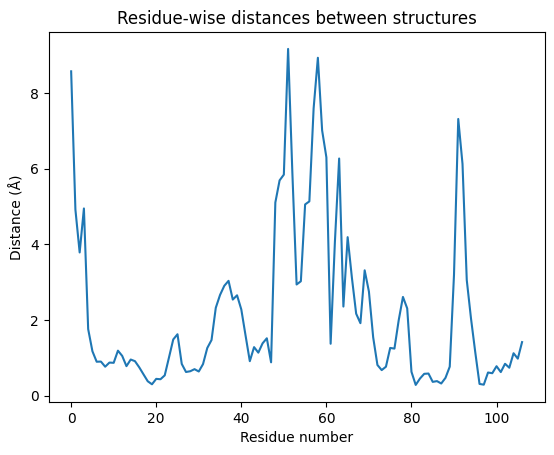

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
|||||||||||||||||||||||||||||||||||
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
  Score=35

RMSD: 3.0543443302728996
Average residue distance: 2.1888 Å



In [14]:
# Import necessary libraries
from Bio.PDB import PDBParser, PPBuilder
from Bio.PDB.Superimposer import Superimposer
from Bio import pairwise2
from Bio.SeqUtils import seq1
import matplotlib.pyplot as plt
import numpy as np

# Define file paths
correct_pdb_path = "/content/jaxalpha/org_pdb_AF/7JTL/Cor_str.pdb"
query_pdb_path = "/content/jaxalpha/pred_pdb_mmseq_gp/ranked_0/7JTL/query.pdb"

# Create a parser
parser = PDBParser()

# Parse the PDB files
structure_correct = parser.get_structure("correct", correct_pdb_path)
structure_query = parser.get_structure("query", query_pdb_path)

# Extract sequences
def get_sequence(structure):
    ppb = PPBuilder()
    seq = ""
    for pp in ppb.build_peptides(structure):
        seq += seq1(pp.get_sequence())
    return seq

seq_correct = get_sequence(structure_correct)
seq_query = get_sequence(structure_query)

# Perform sequence alignment
alignments = pairwise2.align.globalxx(seq_correct, seq_query)
alignment = alignments[0]

# Print alignment
print(pairwise2.format_alignment(*alignment))

# RMSD Calculation
atoms_correct = [atom for atom in structure_correct.get_atoms() if atom.get_id() == 'CA']
atoms_query = [atom for atom in structure_query.get_atoms() if atom.get_id() == 'CA']

if len(atoms_correct) != len(atoms_query):
    print("Structures have different number of CA atoms.")
else:
    sup = Superimposer()
    sup.set_atoms(atoms_correct, atoms_query)
    sup.apply(structure_query.get_atoms())

    # Calculate RMSD
    rmsd = sup.rms
    print(f"RMSD: {rmsd}")

    # Residue-wise distances
    distances = [np.linalg.norm(a1.coord - a2.coord) for a1, a2 in zip(atoms_correct, atoms_query)]
    average_distance = np.mean(distances)
    print(f"Average residue distance: {average_distance:.4f} Å")

    # Plot residue-wise distances
    plt.plot(distances)
    plt.xlabel('Residue number')
    plt.ylabel('Distance (Å)')
    plt.title('Residue-wise distances between structures')
    plt.show()


In [15]:
import py3Dmol

# Read PDB files
with open(correct_pdb_path, 'r') as file:
    correct_pdb_data = file.read()
with open(query_pdb_path, 'r') as file:
    query_pdb_data = file.read()

# Initialize viewer
viewer = py3Dmol.view(width=800, height=600)
viewer.addModel(correct_pdb_data, 'pdb')
viewer.addModel(query_pdb_data, 'pdb')
viewer.setStyle({'model': 0}, {'cartoon': {'color': 'blue'}})  # Correct structure in blue
viewer.setStyle({'model': 1}, {'cartoon': {'color': 'red'}})   # Query structure in red
viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [16]:
!zip -j /content/result_compare.zip /content/result_compare.txt /content/residue_distances.png /content/distance_distribution.png
from google.colab import files
files.download('/content/result_compare.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: result_compare.txt (deflated 71%)
  adding: residue_distances.png (deflated 6%)
  adding: distance_distribution.png (deflated 25%)

